<center><h1>Altanoveo TP</h1></center>

## Importation des librairies

In [1]:
import numpy as np
import pandas as pd
import json
from glob import glob
import spacy
from collections import Counter
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow import keras

2022-03-10 17:33:28.143281: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-10 17:33:28.143313: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Importation du vocabulaire

In [2]:
nlp = spacy.load("en_core_web_sm")
vocab = list(nlp.vocab.strings)
stop_words = list(nlp.Defaults.stop_words) + ["rt", "click"]

## Fonction de vérification du vocabulaire

In [30]:
def keep_in_voc(sentence):
    doc = nlp(" ".join([token for token in sentence.split(' ') if token in vocab and token not in ["rt", "click"]]))
    lemma_tokens = [token.lemma_ for token, ent in zip(doc, doc.ents) if ent.label_ != 'GPE']
    return ' '.join(lemma_tokens)

## Importation des données

#### Fonction de suppression des émoticons

In [31]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f" 
        u"\u3030"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

#### Parcours des fichiers contenant des tweets et récupération du contenu

In [32]:
texts = pd.DataFrame()
fire_tweets = glob('*/*output_tweet.json')
without_fire_tweets = glob('without_fire/*output*.json')

for tweet in fire_tweets:
    with open(tweet, 'r') as file:
        try:
            content = json.loads(file.read())['data']
            for elt in content:
                if elt['lang'] == 'en':
                    cleaned_text = remove_emoji(elt['text'].replace('#', '').replace('\n', ' ')).lower()
                    cleaned_text = keep_in_voc(cleaned_text)
                    
                    texts = pd.concat([texts, pd.DataFrame.from_dict({'is_fire': [True], 'text': [cleaned_text]})], ignore_index=True)
        except:
            print("Erreur : pas de données dans le fichier")

for tweet in without_fire_tweets:
    with open(tweet, 'r') as file:
        try:
            content = json.loads(file.read())['data']
            for elt in content:
                if elt['lang'] == 'en':
                    cleaned_text = remove_emoji(elt['text'].replace('#', '').replace('\n', ' ')).lower()
                    cleaned_text = keep_in_voc(cleaned_text)
                    texts = pd.concat([texts, pd.DataFrame.from_dict({'is_fire': [False], 'text': [cleaned_text]})], ignore_index=True)
        except:
            print("Erreur : pas de données dans le fichier")

texts.head()

Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier
Erreur : pas de données dans le fichier


,is_fire,text
0,True,


## Tf-idf

In [6]:
vectorizer = TfidfVectorizer(min_df=0, max_features=10000)
vectors = vectorizer.fit_transform(texts['text'])
feature_names = vectorizer.get_feature_names_out()
denselist = vectors.todense().tolist()
tf_idf = pd.DataFrame(denselist, columns=feature_names)
tf_idf

,00,000,01,014,02,03,04,060,07,08,...,zane,zealand,zero,zeus,zimbabwe,zodiac,zoe,zone,zoo,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
data = pd.concat([texts, tf_idf], axis=1)
data.head()

,is_fire,text,00,000,01,014,02,03,04,060,...,zane,zealand,zero,zeus,zimbabwe,zodiac,zoe,zone,zoo,zucchini
0,True,like the fire that be destroy greece and,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,True,greece bring under control as more blaze threa...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,True,try to find a fire here that will help we unde...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,True,greece bring under control as more blaze threa...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,True,greece bring under control as more blaze threa...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(np.asarray(vectors.todense()), data['is_fire'], test_size=0.20)

## Pénalisation de la prédiction des classes

In [60]:
Counter(data['is_fire'])[True]

3568

In [10]:
p0 = len(data) / (2 * Counter(data['is_fire'])[False])
p1 = len(data) / (2 * Counter(data['is_fire'])[True])
class_weights = {0: p0, 1: p1}
print(Counter(data['is_fire']))
print('Poids :', class_weights)

Counter({True: 3568, False: 3567})
Poids : {0: 1.0001401738155313, 1: 0.999859865470852}


## Modélisation

In [11]:
clf = DecisionTreeClassifier(class_weight=class_weights)
clf = clf.fit(X_train, y_train)
justesse = clf.score(X_test, y_test)
justesse

0.9677645409950946

## Matrice de confusion et métriques

In [12]:
tn, fp, fn, tp = confusion_matrix(y_test, clf.predict(X_test)).ravel()
pd.DataFrame.from_dict({'justesse': [justesse], 'précision': [tp/(tp+fp)], 'rappel': [tp/(tp+fn)], 'f1-score': [2*tp/(tp+fp)*tp/(tp+fn)/(tp/(tp+fp)+tp/(tp+fn))]})

,justesse,précision,rappel,f1-score
0,0.967765,0.969914,0.964387,0.967143


## Schéma de l'arbre de déçision

In [13]:
wordcloud = WordCloud(width = 800, height = 800,
    background_color ='white',
    stopwords = set(stop_words),
    min_font_size = 10).generate(" ".join(texts['text']))

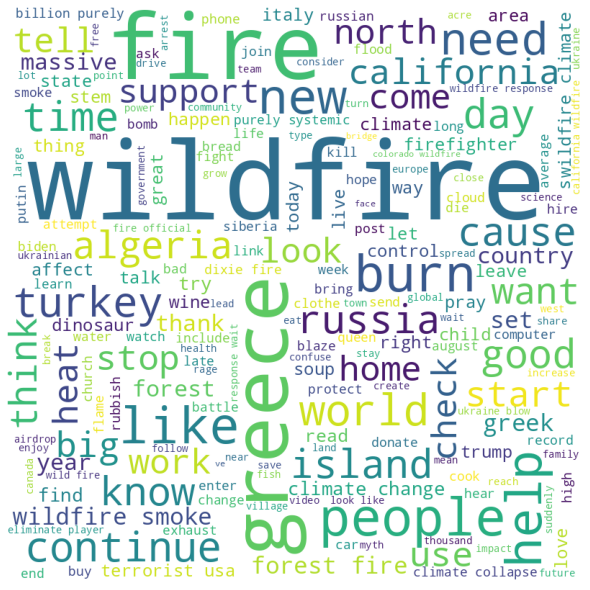

In [14]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

## Régression logistique

In [15]:
reg_model = LogisticRegression(class_weight=class_weights).fit(X_train, y_train)
justesse = reg_model.score(X_test, y_test)
justesse

0.9663629992992292

## Calcul des indicateurs de performance

In [16]:
tn, fp, fn, tp = confusion_matrix(y_test, reg_model.predict(X_test)).ravel()
pd.DataFrame.from_dict({'justesse': [justesse], 'précision': [tp/(tp+fp)], 'rappel': [tp/(tp+fn)], 'f1-score': [2*tp/(tp+fp)*tp/(tp+fn)/(tp/(tp+fp)+tp/(tp+fn))]})

,justesse,précision,rappel,f1-score
0,0.966363,0.989521,0.941595,0.964964


In [17]:
size = 0
coefs = reg_model.coef_[0].tolist()
coef_sum = sum(coefs)
w_words = pd.DataFrame()
while size < 10:
    max_value = max(coefs)
    index = coefs.index(max_value)
    w_words = pd.concat([w_words, pd.DataFrame.from_dict({'index_word': [index], 'weight': [max_value/coef_sum]})])
    coefs[index] = 0
    size += 1

In [18]:
words = [tf_idf.columns[row['index_word']] for index, row in w_words[['index_word']].iterrows()]

Text(0, 0.5, 'poids')

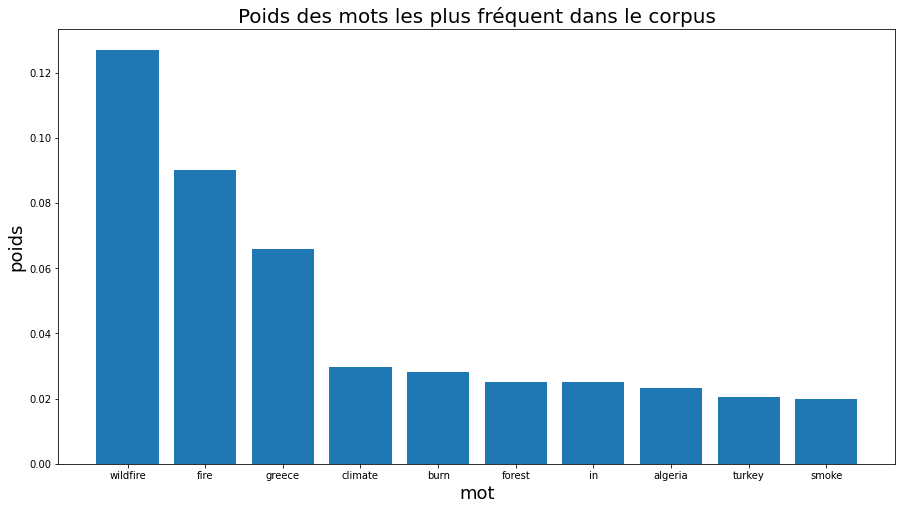

In [19]:
fig, plot = plt.subplots(1, 1)
fig.set_size_inches(15, 8)
plot.bar(words, w_words['weight'])
plot.set_title('Poids des mots les plus fréquent dans le corpus', size=20)
plot.set_xlabel('mot', size=18)
plot.set_ylabel('poids', size=18)

## Utilisation d'un réseau de neurones

In [20]:
model = keras.Sequential()
model.add(keras.Input(shape=(X_train[0].shape)))
model.add(keras.layers.Dense(4000))
model.add(keras.layers.Dense(2000))
model.add(keras.layers.Dense(50))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [23]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=30,
    shuffle=True
)

Epoch 1/30
12/12 [==============================] - 2s 190ms/step - loss: 0.0014 - accuracy: 0.9995
Epoch 2/30
12/12 [==============================] - 2s 184ms/step - loss: 0.0015 - accuracy: 0.9995
Epoch 3/30
12/12 [==============================] - 2s 176ms/step - loss: 0.0014 - accuracy: 0.9995
Epoch 4/30
12/12 [==============================] - 2s 183ms/step - loss: 0.0014 - accuracy: 0.9995
Epoch 5/30
12/12 [==============================] - 2s 177ms/step - loss: 0.0014 - accuracy: 0.9995
Epoch 6/30
12/12 [==============================] - 2s 177ms/step - loss: 0.0021 - accuracy: 0.9984
Epoch 7/30
12/12 [==============================] - 2s 180ms/step - loss: 0.0018 - accuracy: 0.9995
Epoch 8/30
12/12 [==============================] - 2s 176ms/step - loss: 0.0015 - accuracy: 0.9995
Epoch 9/30
12/12 [==============================] - 2s 175ms/step - loss: 0.0015 - accuracy: 0.9995
Epoch 10/30
12/12 [==============================] - 2s 177ms/step - loss: 0.0015 - accuracy: 0.9995

In [24]:
model.evaluate(X_test, y_test)

45/45 [==============================] - 1s 19ms/step - loss: 0.3622 - accuracy: 0.9341


[0.36220550537109375, 0.9341275691986084]